In [5]:
import os
import sys

import pandas as pd
#import pandas_datareader.data as web
import ffn
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

print('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
print(sys.version)

Machine: Darwin x86_64

3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [ ]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [7]:
end = '2015-01-01'
start = '2007-01-01'
symbols = ['SPY','TLT','MSFT']
prices = ffn.get(symbols, start=start, end=end)

In [10]:
prices.pct_change()

,spy,tlt,msft
Date,,,
2007-01-03,NaN,NaN,NaN
2007-01-04,0.002122,0.006063,-0.001675
2007-01-05,-0.007976,-0.004353,-0.005703
2007-01-08,0.004626,0.001793,0.009784
2007-01-09,-0.000850,0.000000,0.001003
...,...,...,...
2014-12-24,0.000096,0.005443,-0.006399
2014-12-26,0.003225,0.003711,-0.005401
2014-12-29,0.001343,0.007475,-0.008981


The Basics
What is a Time Series?
A time series is a series of data points indexed (or listed or graphed) in time order. - Wikipedia

Stationarity
Here I use an infogrpahic found on SeanAbu.com. I find the pictures very intuitive.

View fullsize
Seanabu.com

So what?  Why do we care about stationarity? 

A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.

Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

"For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables." - http://people.duke.edu/~rnau/411diff.htm

With that said, most TS we encounter in finance is NOT stationary. Therefore a large part of TSA involves identifying if the series we want to predict is stationary, and if it is not we must find ways to transform it such that it is stationary. (More on that later)

Serial Correlation (Autocorrelation)
Essentially when we model a time series we decompose the series into three components: trend, seasonal/cyclical, and random. The random component is called the residual or error. It is simply the difference between our predicted value(s) and the observed value(s). Serial correlation is when the residuals (errors) of our TS models are correlated with each other. 

Why Do We Care about Serial Correlation? 
We care about serial correlation because it is critical for the validity of our model predictions, and is intrinsically related to stationarity. Recall that the residuals (errors) of a stationary TS are serially uncorrelated by definition! If we fail to account for this in our models the standard errors of our coefficients are underestimated, inflating the size of our T-statistics. The result is too many Type-1 errors, where we reject our null hypothesis even when it is True! In layman's terms, ignoring autocorrelation means our model predictions will be bunk, and we're likely to draw incorrect conclusions about the impact of the independent variables in our model. 

White Noise and Random Walks
White noise is the first Time Series Model (TSM) we need to understand. By definition a time series that is a white noise process has serially UNcorrelated errors and the expected mean of those errors is equal to zero. Another description for serially uncorrelated errors is, independent and identically distributed (i.i.d.). This is important because, if our TSM is appropriate and successful at capturing the underlying process, the residuals of our model will be i.i.d. and resemble a white noise process. Therefore part of TSA is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it. Below I introduce a convenience function for plotting the time series and analyzing the serial correlation visually. 

In [11]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

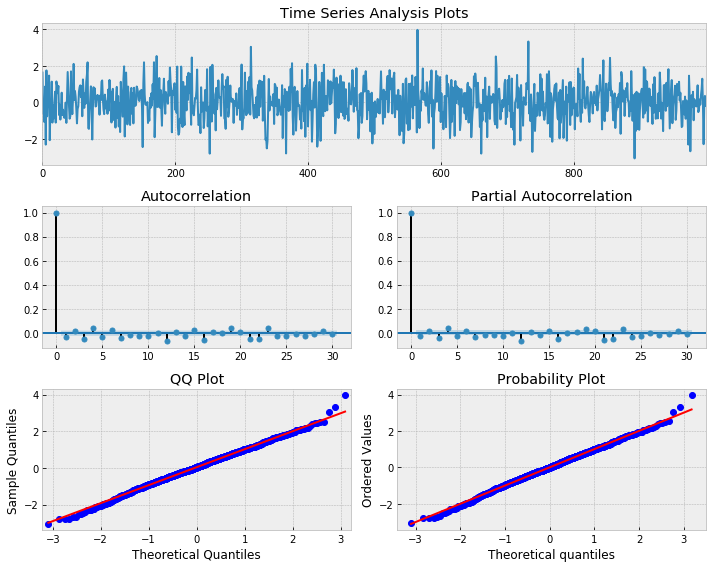

In [12]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

We can see that process appears to be random and centered about zero. The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation. Keep in mind we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution. Below that we can see the QQ and Probability Plots, which compares the distribution of our data with another theoretical distribution. In this case, that theoretical distribution is the standard normal distribution. Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

In [13]:
print("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


# Time Series

## What is a Time Series?
A time series is a sequence where a metric is recorded over regular time intervals.

Depending on the frequency, a time series can be of yearly (ex: annual budget), quarterly (ex: expenses), monthly (ex: air traffic), weekly (ex: sales qty), daily (ex: weather), hourly (ex: stocks price), minutes (ex: inbound calls in a call canter) and even seconds wise (ex: web traffic).

It is very important to learn how to analyze a time series because it is the preparatory step before you develop a forecast of the series.
Besides, time series forecasting has enormous commercial significance because stuff that is important to a business like demand and sales, number of visitors to a website, stock price etc are essentially time series data.

Time series analysis involves understanding various aspects about the inherent nature of the series so that you are better informed to create meaningful and accurate forecasts.

The data for a time series typically stores in .csv files or other spreadsheet formats and contains two columns: the date and the measured value. Sometimes you may have additional values that increase the number of available columns. It may also contains one or more related variables that are measured for the same time periods. Clearly the best instrument to deal with time series is the $\tt{pandas}$ package.

In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Import as Dataframe
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


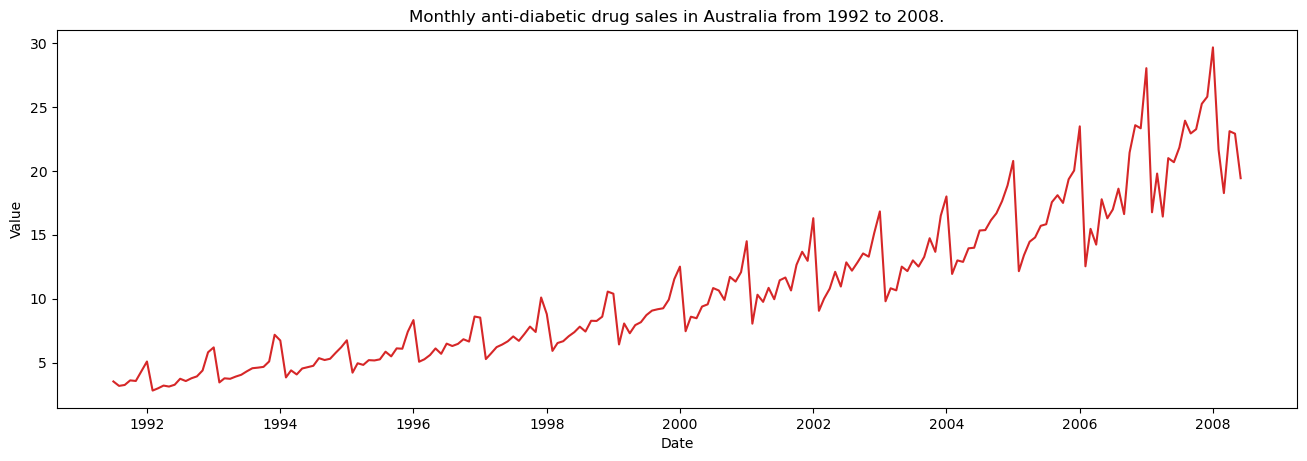

In [2]:
# Time series data source: fpp pacakge in R.
import matplotlib.pyplot as plt
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')    

Since its a monthly time series and follows a certain repetitive pattern every year, you can plot each year as a separate line in the same plot. This lets you compare the year wise patterns side-by-side.

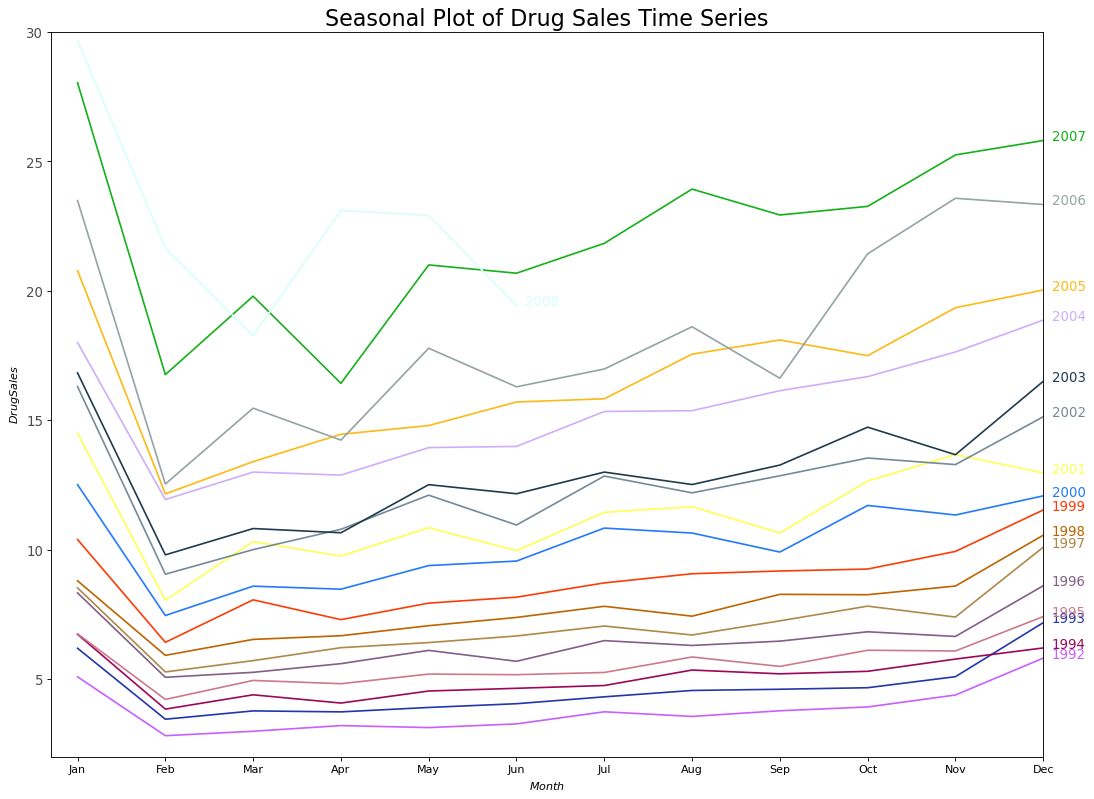

In [3]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

There is a steep fall in drug sales every February, rising again in March, falling again in April and so on. Clearly, the pattern repeats within a given year, every year.

However, as years progress, the drug sales increase overall. You can nicely visualize this trend and how it varies each year in a nice year-wise boxplot. Likewise, you can do a month-wise boxplot to visualize the monthly distributions.

Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

You can group the data at seasonal intervals and see how the values are distributed within a given year or month and how it compares over time.

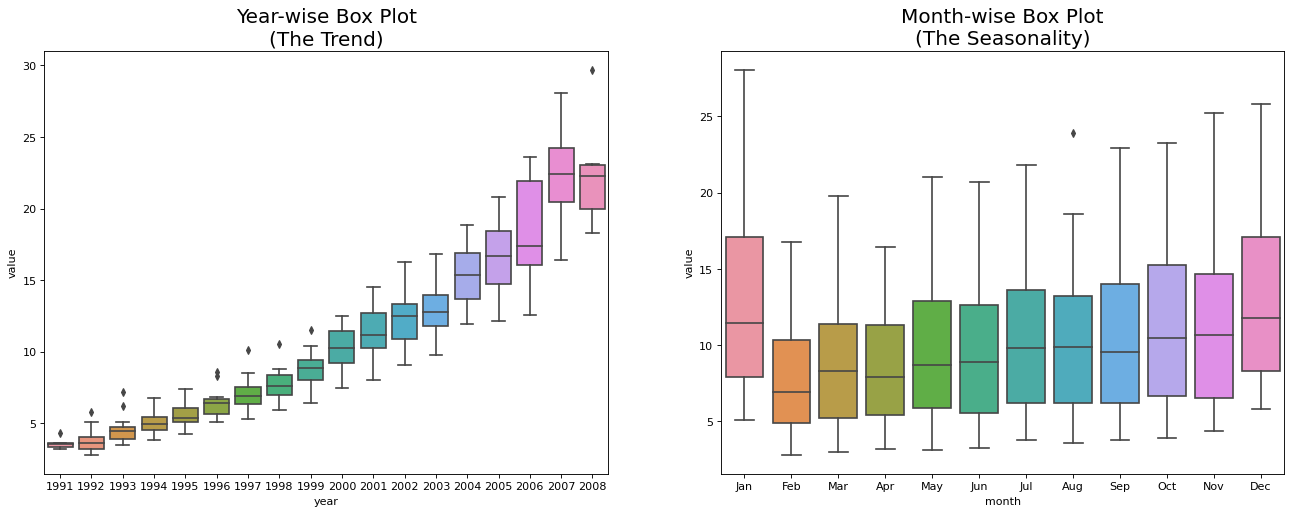

In [4]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

The boxplots make the year-wise and month-wise distributions evident. Also, in a month-wise boxplot, the months of December and January clearly has higher drug sales, which can be attributed to the holiday discounts season.

## Patterns in a time series
So far, we have seen the similarities to identify the pattern. Now, how to find out any deviations from the usual pattern?

Any time series may be split into the following components

* Base Level;
* Trend: a trend is observed when there is an increasing or decreasing slope observed in the time series:
* Seasonality: is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day;
* Error.

However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.

So, a time series may be imagined as a combination of the trend, seasonality and the error terms.

<AxesSubplot:title={'center':'Trend and Seasonality'}, xlabel='date'>

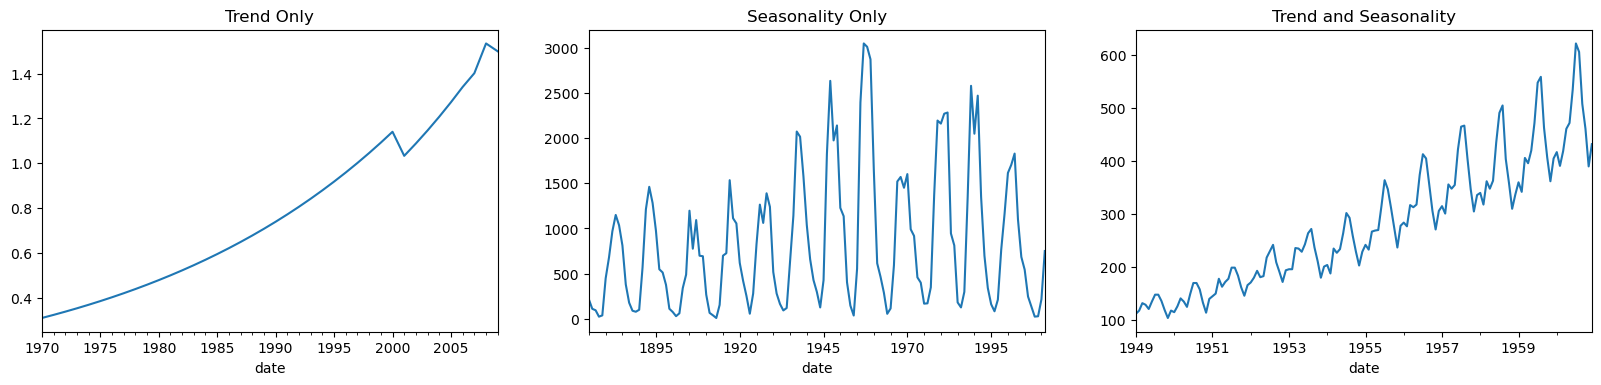

In [5]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

Another aspect to consider is the cyclic behaviour. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect.

If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

### Additive and multiplicative time series
Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

* Additive time series: Value = Base Level + Trend + Seasonality + Error
* Multiplicative Time Series: Value = Base Level x Trend x Seasonality x Error

## How to decompose a time series into its components?
You can do a classical decomposition of a time series by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.

The seasonal_decompose in $\tt{statsmodels}$ implements this conveniently.

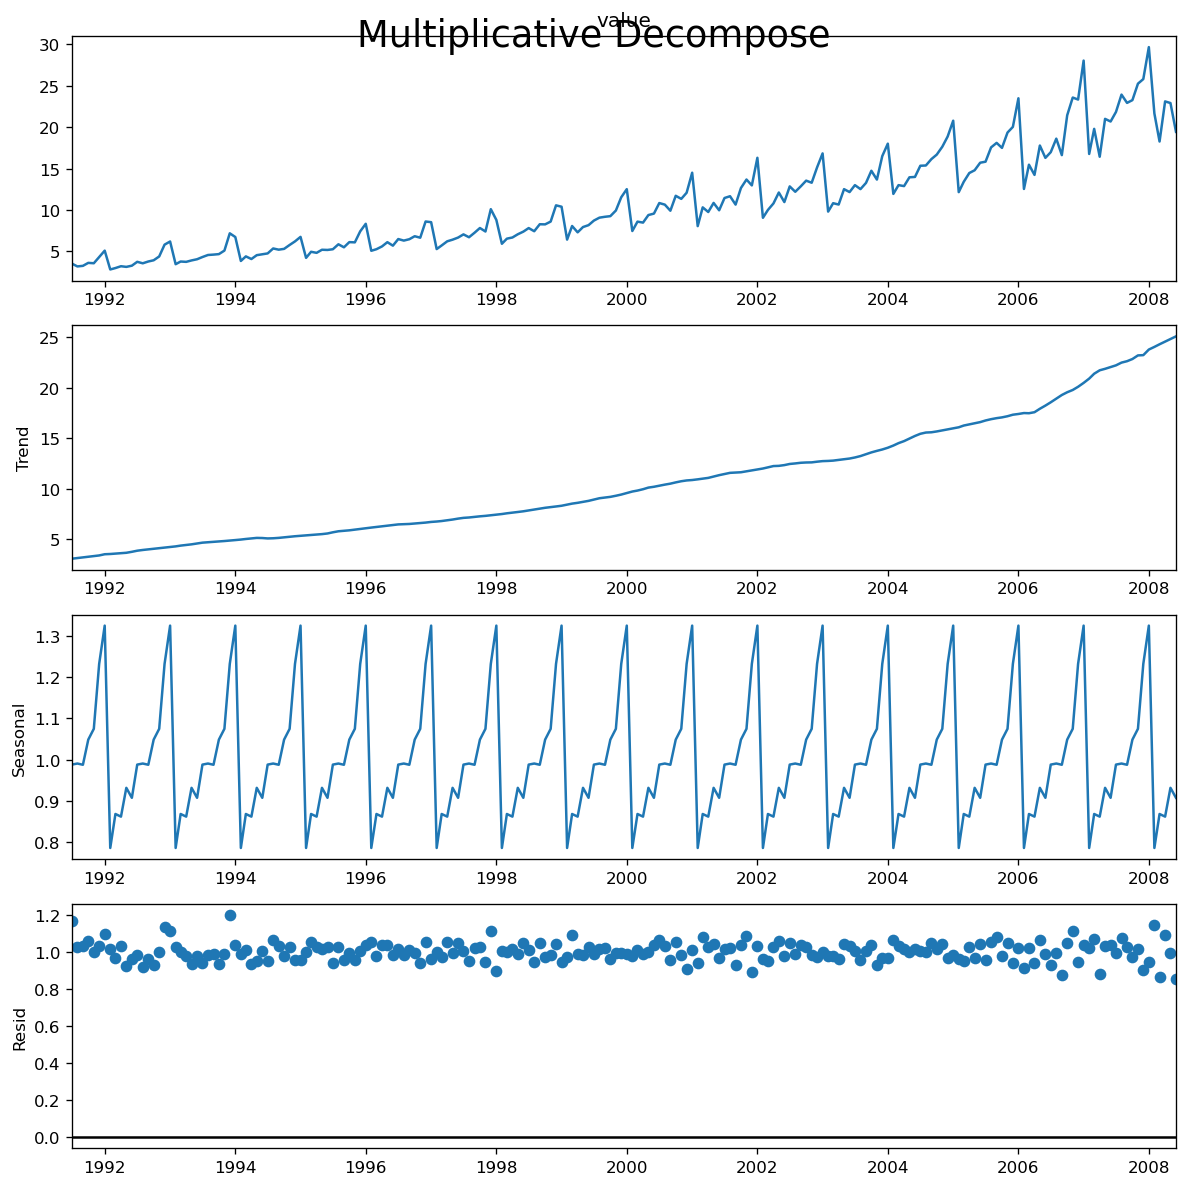

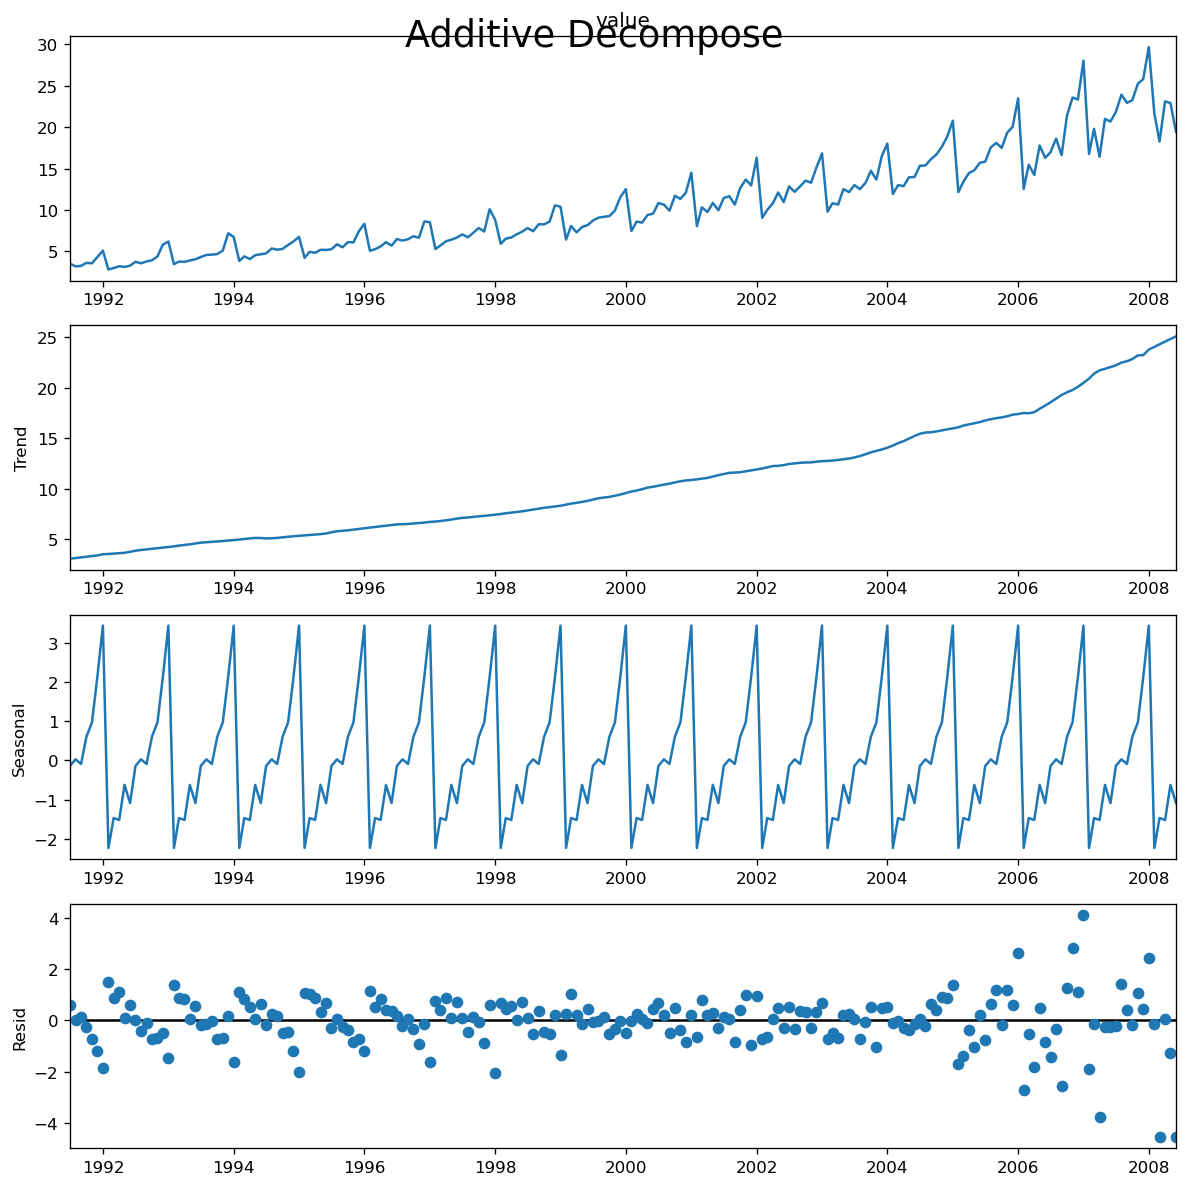

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Setting $\tt{extrapolate_trend='freq'}$ takes care of any missing values in the trend and residuals at the beginning of the series.

If you look at the residuals of the additive decomposition closely, it has some pattern left over. The multiplicative decomposition, however, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.

The numerical output of the trend, seasonal and residual components are stored in the $\tt{result_mul}$ output itself. Let’s extract them and put it in a dataframe.

In [7]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


If you check, the product of $\tt{seas}$, $\tt{trend}$ and $\tt{resid}$ columns should exactly equal to the $\tt{actual_values}$.

## Stationary and Non-Stationary Time Series
Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time.

That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. Autocorrelation of the series is nothing but the correlation of the series with its previous values, more on this coming up.

A stationary time series is lacking of seasonal effects as well.

So how to identify if a series is stationary or not? Let’s plot some examples to make it clear:

So why does a stationary series matter? why am I even talking about it?

I will come to that in a bit, but understand that it is possible to make nearly any time series stationary by applying a suitable transformation. Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.

### How to make a time series stationary?
You can make series stationary by:

* Differencing the Series (once or more)
* Take the log of the series
* Take the nth root of the series
* Combination of the above

The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary.

So what is differencing?

If $Y_t$ is the value at time $t$, then the first difference of $Y = Y_t – Y_{t-1}$. In simpler terms, differencing the series is nothing but subtracting the next value by the current value.

If the first difference doesn’t make a series stationary, you can go for the second differencing. And so on.

For example, consider the following series: [1, 5, 2, 12, 20]

First differencing gives: [5-1, 2-5, 12-2, 20-12] = [4, -3, 10, 8]

Second differencing gives: [-3-4, -10-3, 8-10] = [-7, -13, -2]

### Why make a non-stationary series stationary before forecasting?
Forecasting a stationary series is relatively easy and the forecasts are more reliable.

An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors.

We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent.

Now that we’ve established that stationarizing the series important, how do you check if a given series is stationary or not?

### How to test for stationarity?
The stationarity of a series can be established by looking at the plot of the series like we did earlier.

Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

Nevertheless, you need a method to quantitatively determine if a given series is stationary or not. This can be done using statistical tests called `Unit Root Tests`. There are multiple variations of this, where the tests check if a time series is non-stationary and possess a unit root.

There are multiple implementations of Unit Root tests like:

* Augmented Dickey Fuller test (ADF Test)
* Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
* Philips Perron test (PP Test)

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the p-Value in ADF test is less than the significance level (0.05), you reject the null hypothesis.

In [8]:
from statsmodels.tsa.stattools import adfuller
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.145185689306739
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


### What is the difference between white noise and a stationary series?
Like a stationary series, the white noise is also not a function of time, that is its mean and variance does not change over time. But the difference is, the white noise is completely random with a mean of 0.

In white noise there is no pattern whatsoever. If you consider the sound signals in an FM radio as a time series, the blank sound you hear between the channels is white noise.

Mathematically, a sequence of completely random numbers with mean zero is a white noise.

<AxesSubplot:title={'center':'Random White Noise'}>

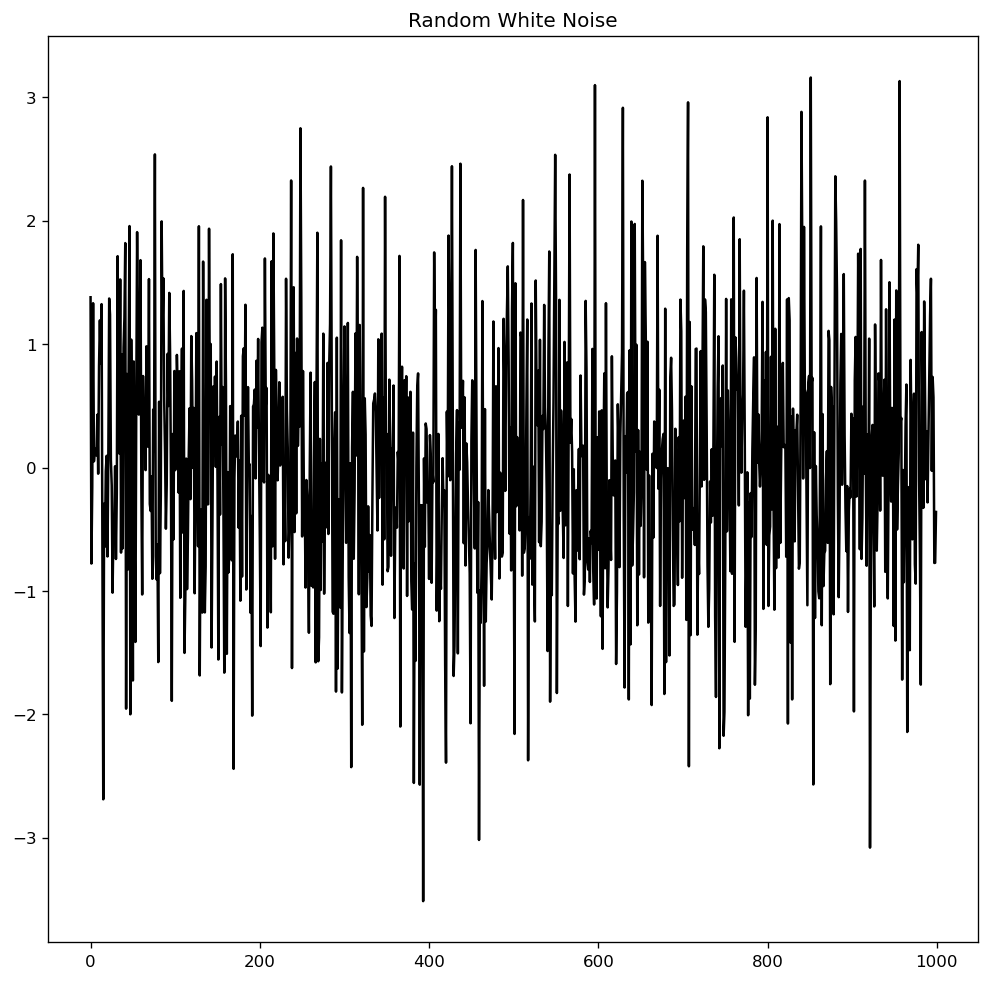

In [9]:
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k')

## How to detrend a time series?
Detrending a time series is to remove the trend component from a time series. But how to extract the trend? There are multiple approaches.

Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms $(x^2)$ in the model.
Subtract the trend component obtained from time series decomposition we saw earlier.

Subtract the mean

Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

Let’s implement the first two methods.

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the least squares fit')

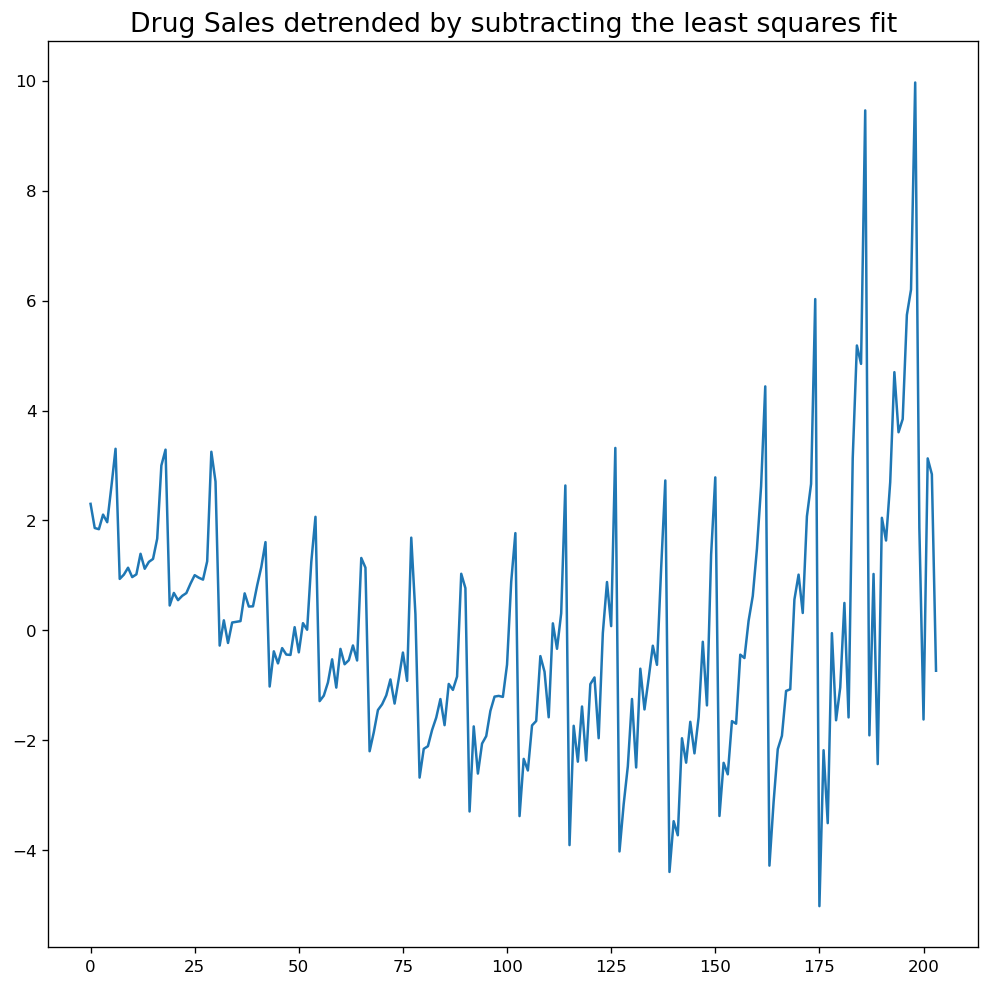

In [10]:
# Using scipy: Subtract the line of best fit
from scipy import signal
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
detrended = signal.detrend(df.value.values)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)


Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

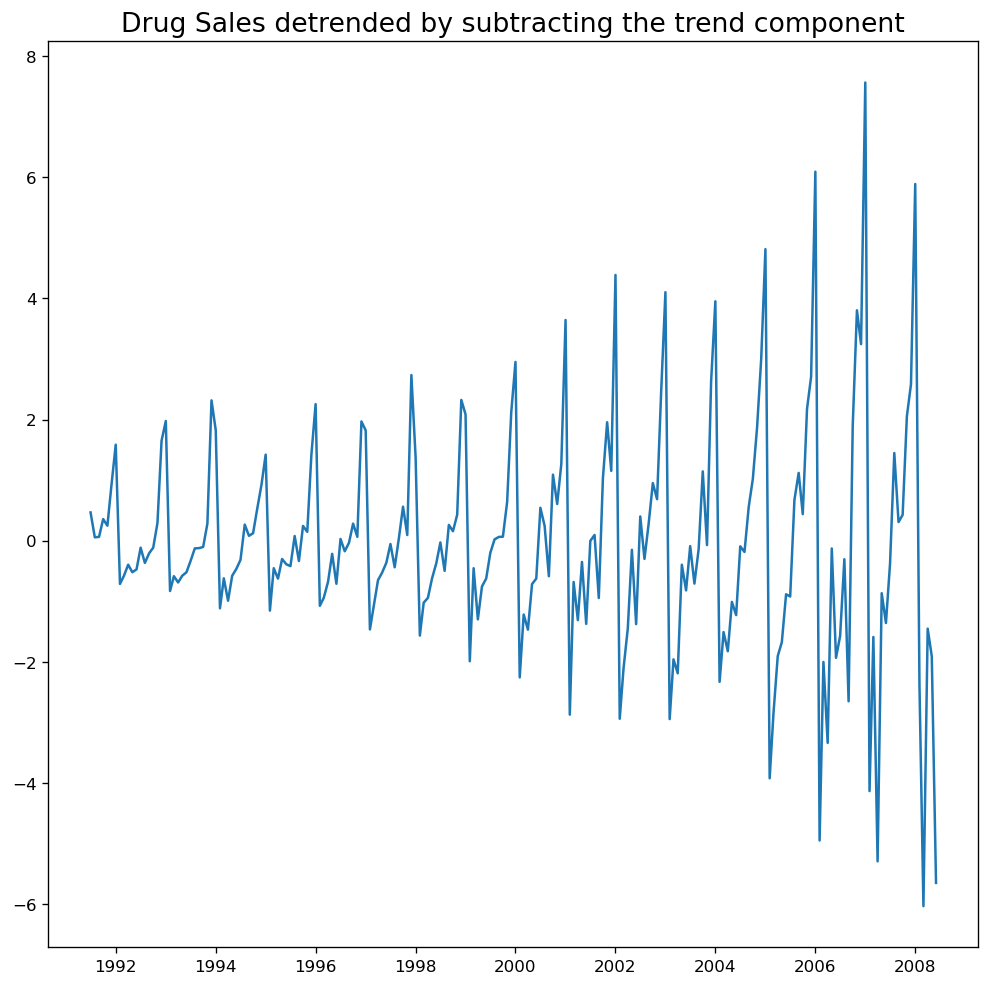

In [11]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

## How to deseasonalize a time series?
There are multiple approaches to deseasonalize a time series as well. Below are a few:

* Take a moving average with length as the seasonal window. This will smoothen in series in the process.
* Seasonal difference the series (subtract the value of previous season from the current value)
* Divide the series by the seasonal index obtained from STL decomposition

If dividing by the seasonal index does not work well, try taking a log of the series and then do the deseasonalizing. You can later restore to the original scale by taking an exponential.

[]

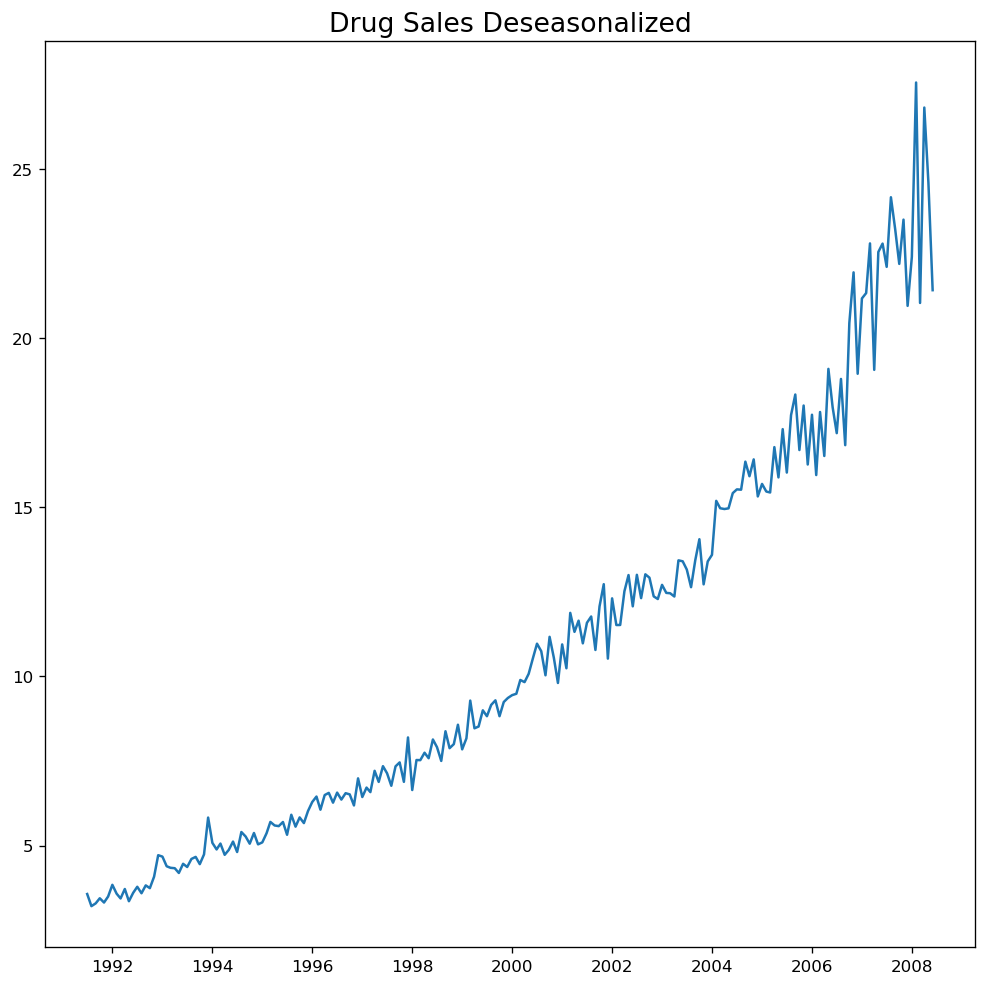

In [12]:
# Subtracting the Trend Component.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Time Series Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df.value.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()


## How to test for seasonality of a time series?
The common way is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar:

* Hour of day
* Day of month
* Weekly
* Monthly
* Yearly

However, if you want a more definitive inspection of the seasonality, use the Autocorrelation Function (ACF) plot. More on the ACF in the upcoming sections. But when there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.

For example, the drug sales time series is a monthly series with patterns repeating every year. So, you can see spikes at 12th, 24th, 36th.. lines.

I must caution you that in real word datasets such strong patterns is hardly noticed and can get distorted by any noise, so you need a careful eye to capture these patterns.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

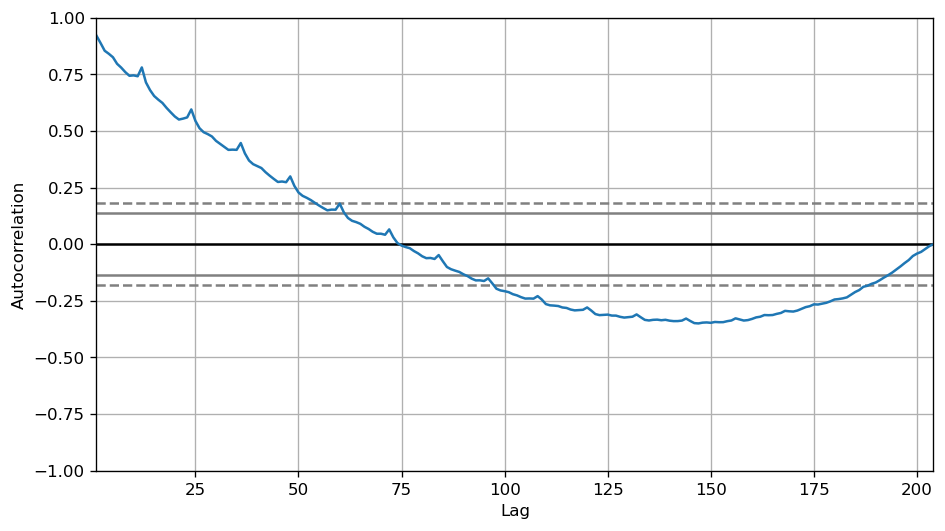

In [13]:
from pandas.plotting import autocorrelation_plot
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())

## What is autocorrelation and partial autocorrelation functions?
Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

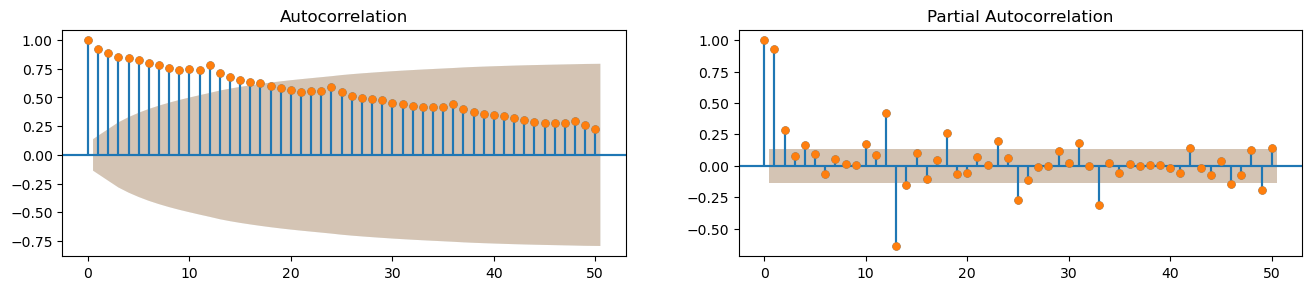

In [15]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

## How to compute partial autocorrelation function?
The partial autocorrelation of lag $(k)$ of a series is the coefficient of that lag in the autoregression equation of $Y$. The autoregressive equation of $Y$ is nothing but the linear regression of $Y$ with its own lags as predictors.

For example, if $Y_t$ is the current series and $Y_{t-1}$ is the lag 1 of $Y$, then the partial autocorrelation of lag 3 $(Y_{t-3})$ is the coefficient $\alpha_3$ of $Y_{t-3}$ in the following equation:

$$Y_t = \alpha_0 + \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + \alpha_3 Y_{t-3} + \ldots$$


### Lag Plots
A lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series like the one you see below, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

In below example on Sunspots area time series, the plots get more and more scattered as the n_lag increases.

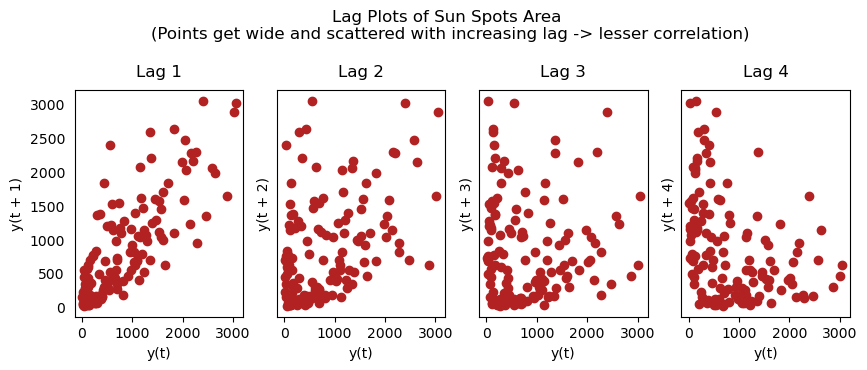

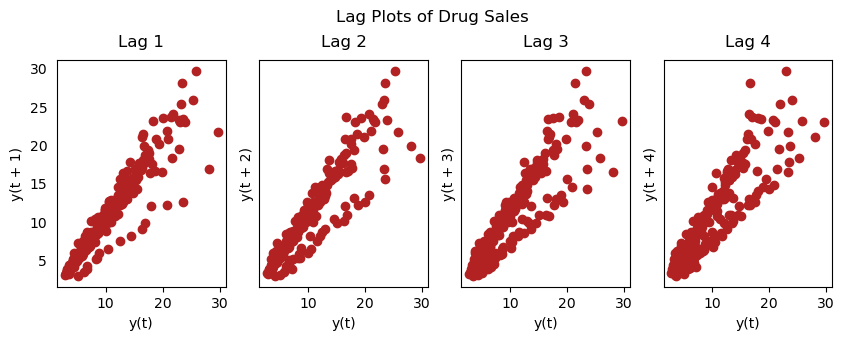

In [16]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Import
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

## How to estimate the forecastability of a time series?
The more regular and repeatable patterns a time series has, the easier it is to forecast. The ‘Approximate Entropy’ can be used to quantify the regularity and unpredictability of fluctuations in a time series.

The higher the approximate entropy, the more difficult it is to forecast it.

Another better alternate is the ‘Sample Entropy’.

Sample Entropy is similar to approximate entropy but is more consistent in estimating the complexity even for smaller time series. For example, a random time series with fewer data points can have a lower ‘approximate entropy’ than a more ‘regular’ time series, whereas, a longer random time series will have a higher ‘approximate entropy’.

Sample Entropy handles this problem nicely. See the demonstration below.

In [17]:
# https://en.wikipedia.org/wiki/Approximate_entropy
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(ss.value, m=2, r=0.2*np.std(ss.value)))     # 0.651
print(ApEn(a10.value, m=2, r=0.2*np.std(a10.value)))   # 0.537
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

0.6514704970333534
0.5374775224973489
0.0898376940798844
0.6725953850207098


In [18]:
# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(ss.value, m=2, r=0.2*np.std(ss.value)))      # 0.78
print(SampEn(a10.value, m=2, r=0.2*np.std(a10.value)))    # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.7853311366380039
0.41887013457621214
inf


/Users/sani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


2.2721258855093374


## Why and How to smoothen a time series?
Smoothening of a time series may be useful in:

* Reducing the effect of noise in a signal get a fair approximation of the noise-filtered series.
* The smoothed version of series can be used as a feature to explain the original series itself.
* Visualize the underlying trend better
So how to smoothen a series? Let’s discuss the following methods:

* Take a moving average
* Do a LOESS smoothing (Localized Regression)
* Do a LOWESS smoothing (Locally Weighted Regression)

Moving average is nothing but the average of a rolling window of defined width. But you must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

LOESS, short for ‘LOcalized regrESSion’ fits multiple regressions in the local neighborhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to fit a regression model.

Download dataset: Elecequip.csv

How to use Granger Causality test to know if one time series is helpful in forecasting another?
Granger causality test is used to determine if one time series will be useful to forecast another.

How does Granger causality test work?

It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y AND the previous values of X should outperform the forecast of Y based on previous values of Y alone.

So, understand that Granger causality should not be used to test if a lag of Y causes Y. Instead, it is generally used on exogenous (not Y lag) variables only.

It is nicely implemented in the statsmodel package.

It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X) is in the second column.

The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful.

The second argument maxlag says till how many lags of Y should be included in the test.

In the above case, the P-Values are Zero for all tests. So the ‘month’ indeed can be used to forecast the Air Passengers.

## Introduction to Time Series Forecasting
Forecasting is the next step where you want to predict the future values the series is going to take.

But why forecast?

Because, forecasting a time series (like demand and sales) is often of tremendous commercial value.

In most manufacturing companies, it drives the fundamental business planning, procurement and production activities. Any errors in the forecasts will ripple down throughout the supply chain or any business context for that matter. So it’s important to get the forecasts accurate in order to save on costs and is critical to success.

Not just in manufacturing, the techniques and concepts behind time series forecasting are applicable in any business.

Now forecasting a time series can be broadly divided into two types.
If you use only the previous values of the time series to predict its future values, it is called Univariate Time Series Forecasting.

And if you use predictors other than the series (a.k.a exogenous variables) to forecast it is called Multi Variate Time Series Forecasting.

In the following we are going to focus on a particular type of forecasting method called ARIMA modeling.
ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

## Introduction to ARIMA Models
ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: $p$, $d$, $q$ where,

* $p$ is the order of the AR term;
* $q$ is the order of the MA term;
* $d$ is the number of differencing required to make the time series stationary.

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

Let’s first look at the $d$ term.

### What does the $p$, $d$ and $q$ in ARIMA model mean
The first step to build an ARIMA model is to make the time series stationary, because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of $d$, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then $d = 0$.

$p$ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of $Y$ to be used as predictors. And $q$ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

### What are AR and MA models
A pure Auto Regressive (AR only) model is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the ‘lags of $Y_t$’.

$$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + \epsilon_1$$

where, $Y{t-1}$ is the lag1 of the series, $\beta1$ is the coefficient of lag1 that the model estimates and $\alpha$ is the intercept term, also estimated by the model.

Likewise a pure Moving Average (MA only) model is one where $Y_t$ depends only on the lagged forecast errors.

$$Y_t = \alpha + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \ldots + \phi_q \epsilon_{t-q} - q$$
where the error terms are the errors of the autoregressive models of the respective lags. The errors $\epsilon_t$ and $\epsilon{t-1}$ are the errors from the following equations:

$$Y_t = \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_0 Y_{0} + \epsilon_t$$
$$Y_{t-1} = \beta_2 Y_{t-2} + \beta_3 Y_{t-3} + \ldots + \beta_0 Y_{0} + \epsilon_{t-1}$$

That was AR and MA models respectively.
So what does the equation of an ARIMA model look like?

An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

$$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \ldots + \phi_q \epsilon_{t-q}$$

ARIMA model in words:

Predicted $Y_t$ = Constant + Linear combination Lags of $Y$ (upto $p$ lags) + Linear Combination of Lagged forecast errors (upto $q$ lags)

The objective, therefore, is to identify the values of $p$, $d$ and $q$. 

### How to find the order of differencing $(d)$ in ARIMA model

The purpose of differencing is to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

Let’s see how to do it with an example.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test ($\tt{adfuller()}$), from the $\tt{statsmodels}$ package because, you need differencing only if the series is non-stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if p-value > 0.05 we go ahead with finding the order of differencing.

In [3]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Since p-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like

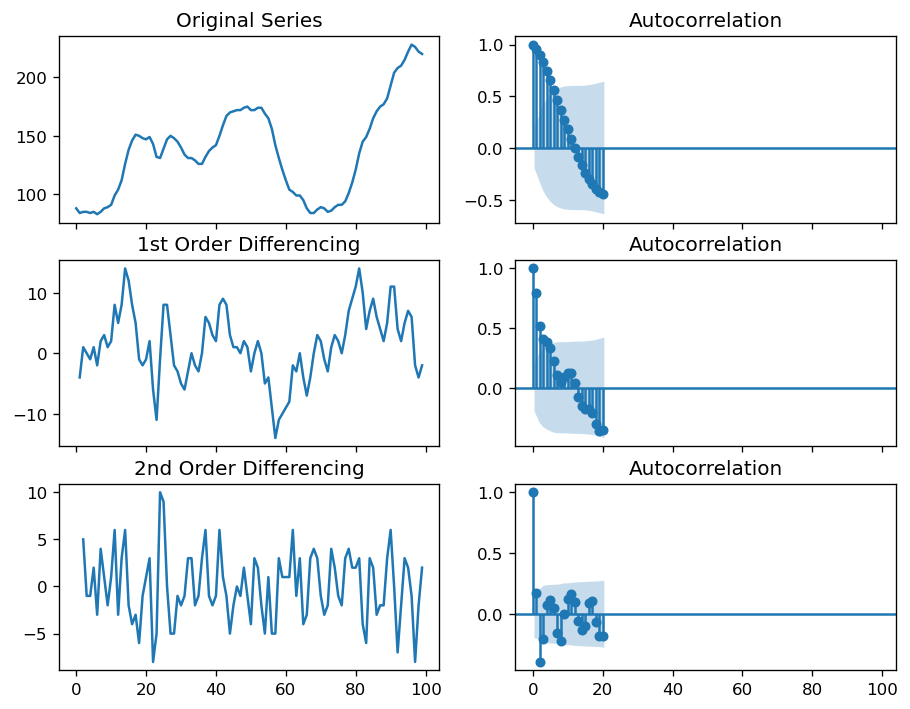

In [2]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

In [4]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value

## Adf Test
ndiffs(y, test='adf')  # 2

ModuleNotFoundError: No module named 'pmdarima'

How to find the order of the AR term (p)
The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

So what is the formula for PACF mathematically?

Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.

$$Yt = \alpha0 + \alpha1 Y{t-1} + \alpha2 Y{t-2} + \alpha3 Y{t-3}$$

That is, suppose, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient $\alpha_3$ of Y_t-3 in the above equation.

Good. Now, how to find the number of AR terms?

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.



In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.

7. How to find the order of the MA term (q)
Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.



In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

8. How to handle if a time series is slightly under or over differenced
It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

How to handle this case?

If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

9. How to build the ARIMA Model
Now that you’ve determined the values of p, d and q, you have everything needed to fit the ARIMA model. Let’s use the ARIMA() implementation in statsmodels package.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, let’s rebuild the model without the MA2 term.

In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

When you set dynamic=False the in-sample lagged values are used for prediction.

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

So, we seem to have a decent ARIMA model. But is that the best?

Can’t say that at this point because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation you need now is the Out-of-Time cross-validation.

10. How to do find the optimal ARIMA model manually using Out-of-Time Cross validation
In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

You can now build the ARIMA model on training dataset, forecast and plot it.

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

In [ ]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

Ideally, you should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how your forecasts are performing at various points in the year.

Here’s a great practice exercise: Try to go back 27, 30, 33, 36 data points and see how the forcasts performs. The forecast performance can be judged using various accuracy metrics discussed next.

11. Accuracy Metrics for Time Series Forecast
The commonly used accuracy metrics to judge forecasts are:

Mean Absolute Percentage Error (MAPE)
Mean Error (ME)
Mean Absolute Error (MAE)
Mean Percentage Error (MPE)
Root Mean Squared Error (RMSE)
Lag 1 Autocorrelation of Error (ACF1)
Correlation between the Actual and the Forecast (corr)
Min-Max Error (minmax)
Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

The other error metrics are quantities. That implies, an RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series.

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)


Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.

Now you know how to build an ARIMA model manually.

But in industrial situations, you will be given a lot of time series to be forecasted and the forecasting exercise be repeated regularly.

So we need a way to automate the best model selection process.

12. How to do Auto Arima Forecast in Python
Like R’s popular auto.arima() function, the pmdarima package provides auto_arima() with similar functionality.

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


How to interpret the residual plots in ARIMA model
Let’s review the residual plots using stepwise_fit.

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s forecast.

In [ ]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

How to automatically build SARIMA model in python
The problem with plain ARIMA model is it does not support seasonality.

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

If your model has well defined seasonal patterns, then enforce D=1 for a given frequency ‘x’.

Here’s some practical advice on building SARIMA model:

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.

Let’s build an SARIMA model on 'a10' – the drug sales dataset.

In [ ]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

As you can clearly see, the seasonal spikes is intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

Let’s build the SARIMA model using pmdarima‘s auto_arima(). To do that, you need to set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.

In [ ]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

The model has estimated the AIC and the P values of the coefficients look significant. Let’s look at the residual diagnostics plot.

The best model SARIMAX(3, 0, 0)x(0, 1, 1, 12) has an AIC of 528.6 and the P Values are significant.

Let’s forecast for the next 24 months.

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

How to build SARIMAX Model with exogenous variable
The SARIMA model we built is good. I would stop here typically.

But for the sake of completeness, let’s try and force an external predictor, also called, ‘exogenous variable’ into the model. This model is called the SARIMAX model.

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

For the sake of demonstration, I am going to use the seasonal index from the classical seasonal decomposition on the latest 36 months of data.

Why the seasonal index? Isn’t SARIMA already modeling the seasonality, you ask?

You are correct.

But also, I want to see how the model looks if we force the recent seasonality pattern into the training and forecast.

Secondly, this is a good variable for demo purpose. So you can use this as a template and plug in any of your variables into the code. The seasonal index is a good exogenous variable because it repeats every frequency cycle, 12 months in this case.

So, you will always know what values the seasonal index will hold for the future forecasts.

In [ ]:
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

Let’s compute the seasonal index so that it can be forced as a (exogenous) predictor to the SARIMAX model.

In [ ]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

The exogenous variable (seasonal index) is ready. Let’s build the SARIMAX model.

In [ ]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

So, we have the model with the exogenous term. But the coefficient is very small for x1, so the contribution from that variable will be negligible. Let’s forecast it anyway.

We have effectively forced the latest seasonal effect of the latest 3 years into the model instead of the entire history.

Alright let’s forecast into the next 24 months. For this, you need the value of the seasonal index for the next 24 months.

In [ ]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

Practice Exercises
In the AirPassengers dataset, go back 12 months in time and build the SARIMA forecast for the next 12 months.

Is the series stationary? If not what sort of differencing is required?
What is the order of your best model?
What is the AIC of your model?
What is the MAPE achieved in OOT cross-validation?
What is the order of the best model predicted by auto_arima() method?